In [1]:
# Selecting v1.15 of tf
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
import tensorflow
# Checking that I use the correct version
print(tensorflow.__version__)

1.15.2


In [3]:
# Connect to gdrive to read csv file
from google.colab import drive
# Set force_remount=True to ensure any changed file is mounted
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
# Import libraries and useful functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from matplotlib.colors import ListedColormap
%matplotlib inline
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

#To display all columns/rows in the dataframes
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings('ignore')

In [6]:
df=pd.read_csv('/content/gdrive/My Drive/stock_pred/final_dataset.csv',
               sep = ';',
               index_col='Date')

df.index=pd.to_datetime(df.index)

In [7]:
# Some pre-processing
df = df.fillna(method='bfill')

In [8]:
# Train Val Test Split

import datetime as dt
import time

series=df['Close']

train_start = dt.date(2008,8,8)
train_end = dt.date(2013,12,31)
train_data = series.loc[train_start:train_end].values.reshape(-1,1)

val_start = dt.date(2014,1,1)
val_end = dt.date(2015,3,31)
val_data = series.loc[val_start:val_end].values.reshape(-1,1)

test_start = dt.date(2015,4,1)
test_end = dt.date(2016,6,30)
test_data = series.loc[test_start:test_end].values.reshape(-1,1)

print(train_data.shape,val_data.shape,test_data.shape)

(1359, 1) (313, 1) (315, 1)


In [9]:
# Normalisation
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)
print(train.shape,val.shape,test.shape)

(1359, 1) (313, 1) (315, 1)


In [10]:
X_train = []
Y_train = []

X_val = []
Y_val = []

X_test = []
Y_test = []

seq_length = 21

# Loop for training data
for i in range(seq_length,train.shape[0]):
    X_train.append(train[i-seq_length:i])
    Y_train.append(train[i][0])
X_train,Y_train = np.array(X_train),np.array(Y_train)

# Loop for validation data
for i in range(seq_length,val.shape[0]):
    X_val.append(val[i-seq_length:i])
    Y_val.append(val[i][0])
X_val,Y_val = np.array(X_val),np.array(Y_val)

# Loop for testing data
for i in range(seq_length,test.shape[0]):
    X_test.append(test[i-seq_length:i])
    Y_test.append(test[i][0])
X_test,Y_test = np.array(X_test),np.array(Y_test)

In [ ]:
# Reshaping data

#X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [11]:
# Define the LSTM model

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.optimizers import Adam

lr=0.01
epochs=200
opt = Adam(lr=lr, decay=lr/epochs)
batch_size=32

model = Sequential()
model.add(LSTM(500, activation='sigmoid', input_shape=(X_train.shape[1], 
                                                       X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'linear'))

model.compile(loss='mean_squared_error', optimizer=opt)

# train the model
print("[INFO] training model...")
model.fit(x=X_train, 
          y=Y_train, 
					validation_data=(X_val, Y_val),
					epochs=epochs, 
					batch_size=batch_size)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Using TensorFlow backend.


[INFO] training model...

Train on 1338 samples, validate on 292 samples
Epoch 1/200
1338/1338 [==============================] - 3s 2ms/step - loss: 6.2526 - val_loss: 0.3898
Epoch 2/200
1338/1338 [==============================] - 1s 642us/step - loss: 0.0405 - val_loss: 0.5031
Epoch 3/200
1338/1338 [==============================] - 1s 661us/step - loss: 0.0388 - val_loss: 0.5062
Epoch 4/200
1338/1338 [==============================] - 1s 655us/step - loss: 0.0384 - val_loss: 0.4947
Epoch 5/200
1338/1338 [==============================] - 1s 676us/step - loss: 0.0382 - val_loss: 0.4175
Epoch 6/200
1338/1338 [==============================] - 1s 679us/step - loss: 0.0365 - val_loss: 0.4483
Epoch 7/200
1338/1338 [==============================] - 1s 660us/step - loss: 0.0358 - val_loss: 0.4339
Epoch 8/200
1338/1338 [==============================] - 1s 649us/step - loss: 0.0321 - val_loss: 0.4153
Epoch 9/200
1338/1338 [==============================] - 1s 659us/step - loss: 0.0257 - v

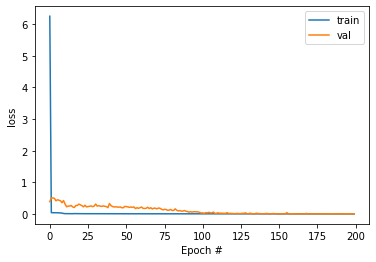

In [12]:
# Plot the losses during the training

plt.plot(model.history.history['loss'], label='train')
plt.plot(model.history.history['val_loss'], label='val')
plt.xlabel("Epoch #")
plt.ylabel("loss")
plt.legend()
plt.show()

In [13]:
# Need to denormalize the target variable in all the sets

y_train_min = train_data.min()
y_train_max = train_data.max() 
y_pred_train = model.predict(X_train)

y_pred_train=y_pred_train[:, 0] * (y_train_max - y_train_min) + y_train_min
Y_train_denorm = Y_train * (y_train_max - y_train_min) + y_train_min

## Validation
y_val_min = val_data.min()
y_val_max = val_data.max() 
y_pred_val = model.predict(X_val)

y_pred_val=y_pred_val[:, 0] * (y_val_max - y_val_min) + y_val_min
Y_val_denorm = Y_val * (y_val_max - y_val_min) + y_val_min

## Test
y_test_min = test_data.min()
y_test_max = test_data.max() 
y_pred_test = model.predict(X_test)

y_pred_test=y_pred_test[:, 0] * (y_test_max - y_test_min) + y_test_min
Y_test_denorm = Y_test * (y_test_max - y_test_min) + y_test_min

In [14]:
# Get MSE for each set of predictions

from sklearn.metrics import mean_squared_error

MSE_train = mean_squared_error(Y_train_denorm, y_pred_train)
MSE_val = mean_squared_error(Y_val_denorm, y_pred_val)
MSE_test = mean_squared_error(Y_test_denorm, y_pred_test)

print(f'MSE (train): {MSE_train.mean()}')
print(f'MSE (validation): {MSE_val.mean()}')
print(f'MSE (test): {MSE_test.mean()}')

MSE (train): 0.39946855277794596
MSE (validation): 0.5420222074154278
MSE (test): 1.5696926618117515


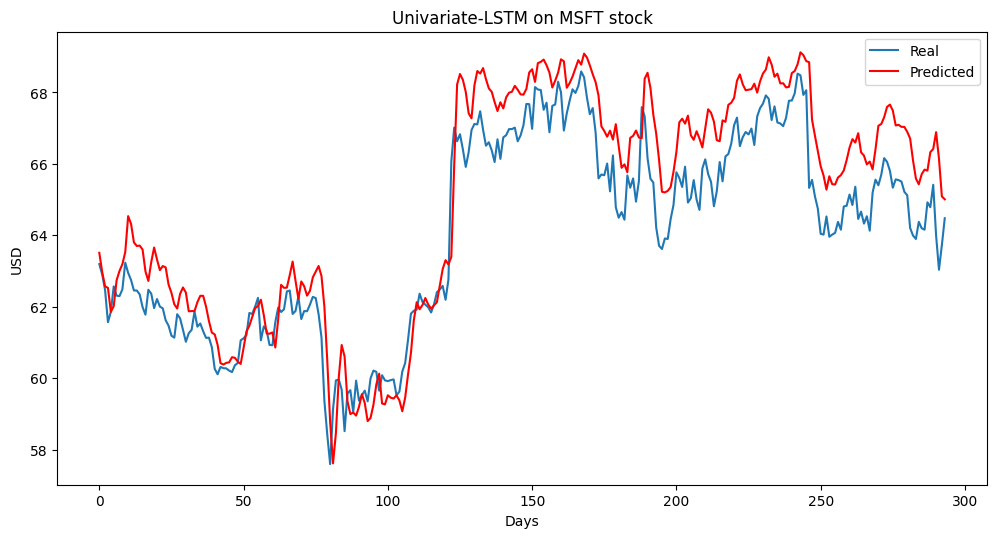

In [15]:
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(Y_test_denorm, label='Real')
plt.plot(y_pred_test, color='red', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Univariate-LSTM on MSFT stock')
plt.legend()
plt.show()

We see how the trained model follows the trend, even though it does not generalize pretty well, probably due to the overfitting on the train set.

I will perform a bit of hyperparameter tuning to see what can I achieve.

In [16]:
import sys
import time
import numpy as np
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM

# Will use Hyper-Opt to find the optimum parameters for the regressor

#Will set an EarlyStopping callback:
# - [monitor]: look at validation loss
# - [min_delta]: quantify the loss amount
# - [patience]: nr of epochs before stopping
# - [verbose]: what to print
# - [mode]: the direction we want to track (e.g. min, max)

def get_callbacks(pars):
  callbacks = [EarlyStopping(monitor = 'val_loss', 
                             min_delta = 0.001, 
                             patience = 2, 
                             verbose= 0, 
                             mode = 'auto')]
  return callbacks

# Defining the space in which fmin() will iterate

space = {'neurons': hp.choice('neurons', [128, 256, 512]),
         'lr': hp.choice('lr',[0.1,0.01, 0.001]),
         'activation_fn': hp.choice('activation_fn',['sigmoid','tanh','relu']),
         'dropout': hp.choice('dropout',[0,0.1,0.2])
        }

def vanilla_LSTM(pars):
  print('Parameters: ', pars)

  # Define the 3 neuron layers
  model = Sequential()
  model.add(LSTM(pars['neurons'], 
                  activation = pars['activation_fn'], 
                  input_shape=(X_train.shape[1], X_train.shape[2])))
  model.add(Dropout(pars['dropout']))
  # Last unique linear activation for regression
  model.add(Dense(1, activation = 'linear'))

  # Define optimizer with learning rate as optimizable parameter 
  opt = Adam(lr = pars['lr'], decay = pars['lr'])
  
  # Compile the model
  model.compile(optimizer = opt, loss = 'mean_squared_error')

  # We now train the model
  history = model.fit(x=X_train, 
                      y=Y_train, 
					            validation_data=(X_val, Y_val),
	                    epochs = 20, 
                      batch_size = 32,
                      callbacks = get_callbacks(pars))
  
  # Save the losses and print them
  best_epoch_loss = np.argmin(history.history['val_loss'])
  best_val_loss = np.min(history.history['val_loss'])
  print('Epoch {} -  val loss: {}'.format(best_epoch_loss, best_val_loss))
  
  #This will let us see the progress while the script is still running
  sys.stdout.flush()

  return {'loss': best_val_loss, 'best_epoch': best_epoch_loss, 'eval_time': time.time(), 'status': STATUS_OK, 'model': model, 'history': history}

trials = Trials()
# Use of fmin(), in which we put: 
#   - the defined function to minimize, 
#   - our space to iterate
#   - algorithm used: Tree of Parsen Estimators (TPE)
#   - maximum nr of evaluations 
#   - trials are used to see the results of each evaluation
best = fmin(vanilla_LSTM, space, algo = tpe.suggest, max_evals = 10, trials = trials)
print(best)

Parameters: 
{'activation_fn': 'relu', 'dropout': 0.1, 'lr': 0.01, 'neurons': 512}
Train on 1338 samples, validate on 292 samples
Epoch 1/20
  32/1338 [..............................]
 - ETA: 12s - loss: 0.3206

 128/1338 [=>............................]
 - ETA: 3s - loss: 0.1826 

 192/1338 [===>..........................]
 - ETA: 2s - loss: 0.1834

 256/1338 [====>.........................]
 - ETA: 2s - loss: 0.1551

 320/1338 [======>.......................]
 - ETA: 1s - loss: 0.3726

 384/1338 [=======>......................]
 - ETA: 1s - loss: 0.3329

 448/1338 [=========>.............

In [17]:
trials.losses()

[0.0036387994609556277,
 0.40457172059033014,
 0.002851999230835944,
 0.003251258653830992,
 0.2796637575103812,
 0.357023442852987,
 0.38865989364989817,
 0.002848637083781347,
 0.14050604607144448,
 0.0025662525368803373]

In [20]:
trials.trials[7]

{'book_time': datetime.datetime(2020, 8, 10, 0, 48, 40, 956000),
 'exp_key': None,
 'misc': {'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'idxs': {'activation_fn': [7], 'dropout': [7], 'lr': [7], 'neurons': [7]},
  'tid': 7,
  'vals': {'activation_fn': [2], 'dropout': [1], 'lr': [1], 'neurons': [2]},
  'workdir': None},
 'owner': None,
 'refresh_time': datetime.datetime(2020, 8, 10, 0, 48, 53, 323000),
 'result': {'best_epoch': 5,
  'eval_time': 1597020533.3230255,
  'history': <keras.callbacks.callbacks.History at 0x7f2563403e10>,
  'loss': 0.002848637083781347,
  'model': <keras.engine.sequential.Sequential at 0x7f2563de53c8>,
  'status': 'ok'},
 'spec': None,
 'state': 2,
 'tid': 7,
 'version': 0}

In [22]:
# Using the optimal hyperparameters
#'vals': {'activation_fn': relu,
#         'dropout': 0.1
#         'lr': 0.01,
#         'neurons': 512}

lr=0.01
epochs=200
opt = Adam(lr=lr, decay=lr/epochs)
batch_size=32

model = Sequential()
model.add(LSTM(512, activation='relu', input_shape=(X_train.shape[1], 
                                                    X_train.shape[2])))
model.add(Dropout(0.1))
model.add(Dense(1, activation = 'linear'))

model.compile(loss='mean_squared_error', optimizer=opt)

# train the model
print("[INFO] training model...")
model.fit(x=X_train, 
          y=Y_train, 
					validation_data=(X_val, Y_val),
					epochs=epochs, 
					batch_size=batch_size)

[INFO] training model...
Train on 1338 samples, validate on 292 samples
Epoch 1/200
1338/1338 [==============================] - 2s 1ms/step - loss: 0.0641 - val_loss: 0.1198
Epoch 2/200
1338/1338 [==============================] - 1s 722us/step - loss: 0.0034 - val_loss: 0.0135
Epoch 3/200
1338/1338 [==============================] - 1s 685us/step - loss: 0.0027 - val_loss: 0.0087
Epoch 4/200
1338/1338 [==============================] - 1s 670us/step - loss: 0.0028 - val_loss: 0.0031
Epoch 5/200
1338/1338 [==============================] - 1s 676us/step - loss: 0.0021 - val_loss: 0.0101
Epoch 6/200
1338/1338 [==============================] - 1s 700us/step - loss: 0.0019 - val_loss: 0.0016
Epoch 7/200
1338/1338 [==============================] - 1s 681us/step - loss: 0.0016 - val_loss: 0.0015
Epoch 8/200
1338/1338 [==============================] - 1s 695us/step - loss: 0.0016 - val_loss: 0.0032
Epoch 9/200
1338/1338 [==============================] - 1s 688us/step - loss: 0.0016 - va

In [23]:
# Need to denormalize the target variable in all the sets

y_train_min = train_data.min()
y_train_max = train_data.max() 
y_pred_train = model.predict(X_train)

y_pred_train=y_pred_train[:, 0] * (y_train_max - y_train_min) + y_train_min
Y_train_denorm = Y_train * (y_train_max - y_train_min) + y_train_min

## Validation
y_val_min = val_data.min()
y_val_max = val_data.max() 
y_pred_val = model.predict(X_val)

y_pred_val=y_pred_val[:, 0] * (y_val_max - y_val_min) + y_val_min
Y_val_denorm = Y_val * (y_val_max - y_val_min) + y_val_min

## Test
y_test_min = test_data.min()
y_test_max = test_data.max() 
y_pred_test = model.predict(X_test)

y_pred_test=y_pred_test[:, 0] * (y_test_max - y_test_min) + y_test_min
Y_test_denorm = Y_test * (y_test_max - y_test_min) + y_test_min

In [24]:
# Get MSE for each set of predictions

from sklearn.metrics import mean_squared_error

MSE_train = mean_squared_error(Y_train_denorm, y_pred_train)
MSE_val = mean_squared_error(Y_val_denorm, y_pred_val)
MSE_test = mean_squared_error(Y_test_denorm, y_pred_test)

print(f'MSE (train): {MSE_train.mean()}')
print(f'MSE (validation): {MSE_val.mean()}')
print(f'MSE (test): {MSE_test.mean()}')

MSE (train): 0.2523929230236918
MSE (validation): 0.12886021239635043
MSE (test): 0.4053914546247616


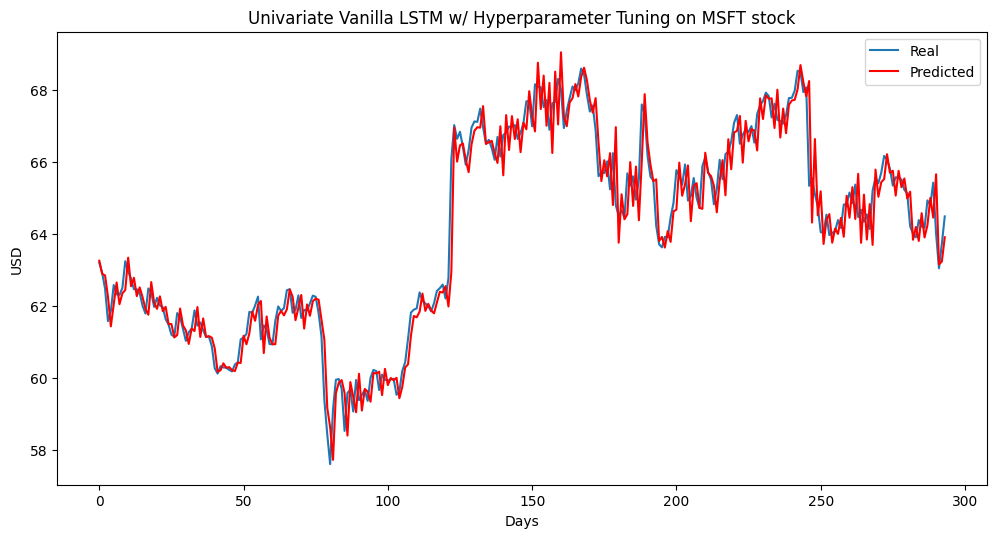

In [25]:
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(Y_test_denorm, label='Real')
plt.plot(y_pred_test, color='red', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Univariate Vanilla LSTM w/ Hyperparameter Tuning on MSFT stock')
plt.legend()
plt.show()